# Linear basis function regression
In this note, we consider the simplest form of linear regression models where $h(\pmb{\mathrm{x}})$ is a linear function of the input variables
$$
y(\pmb{\mathrm{x}},\pmb{\mathrm{w}}) = w_0 + w_1 x_1 + \ldots + w_D x_D
$$
To make our problem more concrete, we consider the [boston housing data](https://archive.ics.uci.edu/ml/datasets/Housing). Go through this exercise, we will learn the following
* get the raw data and preprocess it to a convenient form
* visualize the data via plot
* formulate the maximum likelihood => least squares problem
* solve least square problem with Gradient Descend/Stochastic Gradient Descend
* try it in [TensorFlow](https://www.tensorflow.org/)

Let's get started

## Get the data

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('housing.data'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Housing Dataset') as pbar:
        urlretrieve(
            'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
            'housing.data',
            pbar.hook)

if not isfile('housing.names'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Housing Dataset') as pbar:
        urlretrieve(
            'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names',
            'housing.names',
            pbar.hook)

# print the description of the data
with open('housing.names', 'r') as f:
    print(''.join(f.readlines()))

# print 10 first lines of the data
with open('housing.data', 'r') as f:
    print('10 first lines:')
    for i in range(10):
        print(f.readline())

1. Title: Boston Housing Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the 
                 demand for clean air', J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

3. Past Usage:
   -   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 
       1980.   N.B. Various transformations are used in the table on
       pages 244-261.
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   Concerns housing values in suburbs of Boston.

5. Number of Instances: 506

6. Number of Attributes: 13 continuous attributes (including "class"
                

## Load data
We are interested in predicting house price (MEDV) in regarding to other factors. In order to do so, it might be more convenient to use pandas

In [3]:
import pandas as pd

header = ['crim', 'zn', 'indus', 'chas', 'nox', 
          'rm', 'age', 'dis', 'rad', 'tax', 
          'ptratio', 'b', 'lstat', 'medv']
data = pd.read_csv('housing.data', names = header, delim_whitespace=True)

print(data.head(10))

      crim    zn  indus  chas    nox     rm    age     dis  rad    tax  \
0  0.00632  18.0   2.31     0  0.538  6.575   65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421   78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185   61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998   45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147   54.2  6.0622    3  222.0   
5  0.02985   0.0   2.18     0  0.458  6.430   58.7  6.0622    3  222.0   
6  0.08829  12.5   7.87     0  0.524  6.012   66.6  5.5605    5  311.0   
7  0.14455  12.5   7.87     0  0.524  6.172   96.1  5.9505    5  311.0   
8  0.21124  12.5   7.87     0  0.524  5.631  100.0  6.0821    5  311.0   
9  0.17004  12.5   7.87     0  0.524  6.004   85.9  6.5921    5  311.0   

   ptratio       b  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396

## Visualize data
It is always a good idea to look at the dataset before working with it.

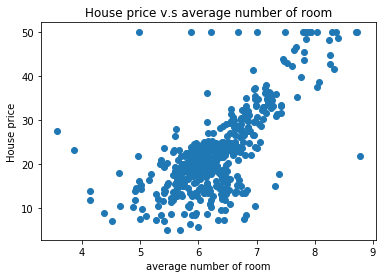

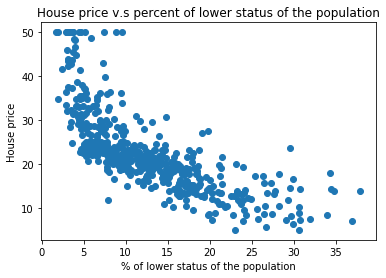

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(data['rm'], data['medv'])
plt.title('House price v.s average number of room')
plt.xlabel('average number of room')
plt.ylabel('House price')
plt.show()

plt.scatter(data['lstat'], data['medv'])
plt.title('House price v.s percent of lower status of the population')
plt.xlabel('% of lower status of the population')
plt.ylabel('House price')

Looking at the plot, we can see some linear dependence between house price v.s rm and lstat + some noise. In order to find these dependence, we introduce the theory of Maximum Likelihood.

## [Maximum Likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)
We assume the real target is given by a deterministic function $t=y(\pmb{\mathrm{x}},\pmb{\mathrm{w}}) + \epsilon$ where $\epsilon$ is a zero mean Gaussian random variable with precision (inverse variance) $\beta$. The Maximum Likelihood is to find $\pmb{\mathrm{w}}$ that maximize the [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function)
$$
p\left(\left\{t^{(i)}\right\}_{i=1}^N|\left\{\pmb{\mathrm{x}}^{(i)}\right\}_{i=1}^N;\pmb{\mathrm{w}}\right)
$$
Assuming $t^{(i)}, \pmb{\mathrm{x}}^{(i)}$ are i.i.d. we have
$$
p\left(\left\{t^{(i)}\right\}_{i=1}^N|\left\{\pmb{\mathrm{x}}^{(i)}\right\}_{i=1}^N;\pmb{\mathrm{w}}\right) = \prod_{i=1}^N p\left(t^{(i)}|\pmb{\mathrm{x}}^{(i)};\pmb{\mathrm{w}}\right)
$$
Note that
$$
p\left(t^{(i)}|\pmb{\mathrm{x}}^{(i)};\pmb{\mathrm{w}}\right) = p\left(\epsilon = t^{(i)} - y(\pmb{\mathrm{x}}^{(i)},\pmb{\mathrm{w}})\right) = \mathcal{N}\left(t^{(i)} - y(\pmb{\mathrm{x}}^{(i)},\pmb{\mathrm{w}}), \beta^{-1}\right)
$$
By taking the $\log$ to above form we obtain
$$
\log p\left(\left\{t^{(i)}\right\}_{i=1}^N|\left\{\pmb{\mathrm{x}}^{(i)}\right\}_{i=1}^N;\pmb{\mathrm{w}}\right) = \sum_{i=1}^N\log \mathcal{N}\left(t^{(i)} - y(\pmb{\mathrm{x}}^{(i)},\pmb{\mathrm{w}}), \beta^{-1}\right)
$$
Simplify above formula, the maximum likelihood function is equivalent to find $w$ to minimize 
$$
\frac{1}{2}\sum_{i=1}^N\left(t^{(i)} - y(\pmb{\mathrm{x}}^{(i)},\pmb{\mathrm{w}})\right)^2
$$
In our concreate problem, our target is house price $\mathrm{medv}^{(i)}$ and input is $\mathrm{lstat}^{(i)}$ and/or $\mathrm{rm}^{(i)}$. For simplification and easier to plot, we consider input is $\mathrm{rm}^{(i)}$, our optimization problem is to find $w_0,w_1$ that minimize
$$
\mathrm{arg}\max_{w_0,w_1}L(w_0,w_1) = \frac{1}{2}\sum_{i=1}^N\left(\mathrm{medv}^{(i)} - w_0 - w_1 \times \mathrm{rm}^{(i)}\right)^2
$$
This particular optimization can be solved by
* closed form solution in [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares)
* first-order iterative optimization algorithm such as [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) and especially [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (often shotened in GD & SGD).

Here, we will use the GD and SGD since it is well applied for a boarder optimization problems (where closed form doesn't exists).

The GD/SGD is well described in aboves links, the main work is to implement the update formula
$$
\pmb{\mathrm{w}} := \pmb{\mathrm{w}} - \eta \nabla_{\pmb{\mathrm{w}}}L(\pmb{\mathrm{w}})
$$
where $\eta>0$ is a chosen learning rate.

Note that since $N$ can vary, we normally use the mean square error to make it independent of $N$, the loss function is re-written as
$$
\mathrm{arg}\max_{w_0,w_1}L(w_0,w_1) = \frac{1}{2N}\sum_{i=1}^N\left(\mathrm{medv}^{(i)} - w_0 - w_1 \times \mathrm{rm}^{(i)}\right)^2
$$

In [4]:
import numpy as np

class LinearModel(object):
    '''
    LinearModel represents the L function which allows us to compute L(w) and grad_w(L(w))
    '''    
    def __init__(self):
        self.weights = np.array([0., 0.])
    

    def loss(self, X, y):
        '''
            X: is input features append 1.0 as first column
               with size (N, 2)
            y: is target variables with size (N,)

            this function compute L(w) and grad_w(L(w))
        '''
        N = X.shape[0]
        tmp = X.dot(self.weights) - y
        cost = 0.5 * np.sum(np.square(tmp))/N
        grads = X.T.dot(tmp)/N
        
        return cost, grads
    
    def update(self, dweights):
        self.weights += dweights

To check our implementation, it's worth to check our gradient implementation v.s numerical gradient (we use the implementation taken from [CS231n](cs231n.stanford.edu) see file *gradient_check.py* for more detail

In [7]:
from gradient_check import eval_numerical_gradient, rel_error

# def rel_error(x, y):
#   """ returns relative error """
#   return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


N = data.shape[0]
X = np.ones((N,2))
X[:,1] = data['rm']
y = data['medv']

lm = LinearModel()
lm.weights = np.random.randn(2)

f = lambda _:lm.loss(X, y)[0]
cost, grads = lm.loss(X, y)
numerical_grads = eval_numerical_gradient(f, lm.weights, verbose = False, h = 1e-6)

# we should see error ~ 1e-9 or smaller
print ('dw error: {:e}'.format(rel_error(grads, numerical_grads)))

dw error: 6.287654e-11


We implement our (Stochastic)Gradient Solver as follow

In [5]:
class GradientDescentSolver(object):
    '''
    A GradientDescentSolver implement the Gradient Descent algorithm.
    
    The solver takes a model and some optimization config dictionary e.g {'learning_rate' : 1e-3}
    
    Each time we call train(X, y) it will compute dweights and call model.update(dweights)
    
    So we can either feed 
        i)  whole data X,y to the solver => Gradient Descent or 
        ii) a batch sub-samples data => Stochastic Gradient Descent
    '''
    def __init__(self, model, optim_config, **kwargs):
        self.model = model
        self.optim_config = optim_config
        
        self.lr = self.optim_config['learning_rate']
        self.lr_decay = kwargs.pop('lr_decay', 1.00)
        self.lr_decay_step = kwargs.pop('lr_decay_step', 100)
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)
        
        self.loss_history = []
        
    def train(self, X, y):
        cost, grad = self.model.loss(X, y)
        self.loss_history.append(cost)
        dweight = -self.lr * grad
        self.model.update(dweight)        
        if self.verbose and len(self.loss_history) % self.print_every == 0:
            print ('Iteration {:5d} loss: {:f}'.format(len(self.loss_history), self.loss_history[-1]))
        if len(self.loss_history) % self.lr_decay_step == 0:
            self.lr *= self.lr_decay

## Try Gradient descent
Let's try Gradient descent first

In [23]:
def fit(initial_w, epochs, optim_config, **kwargs):
    lm = LinearModel()
    lm.weights = initial_w
    solver = GradientDescentSolver(lm, optim_config, **kwargs)

    for i in range(epochs):
        solver.train(X, y)

    print ('optimized weights: ', lm.weights)
    return lm.weights

epochs = 10000
optim_config = {'learning_rate' : 3.0e-2, 'lr_decay' : .95, 'lr_decay_step' : 1000}
initial_w = np.zeros(2)
fitted_weights = fit(initial_w, epochs, optim_config, print_every = 1000)

Iteration  1000 loss: 25.519078
Iteration  2000 loss: 23.607613
Iteration  3000 loss: 22.678641
Iteration  4000 loss: 22.227161
Iteration  5000 loss: 22.007742
Iteration  6000 loss: 21.901104
Iteration  7000 loss: 21.849279
Iteration  8000 loss: 21.824091
Iteration  9000 loss: 21.811850
Iteration 10000 loss: 21.805901
optimized weights:  [-33.71539995   8.95194342]


Let's visualize fitted curve

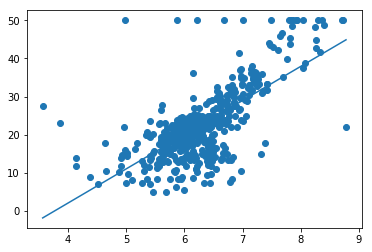

In [24]:
xtest = np.linspace(np.min(data['rm']), np.max(data['rm']))
ytest = fitted_weights[0] + fitted_weights[1] * xtest

plt.scatter(data['rm'], y)
plt.plot(xtest, ytest)

The fitted curve seems to fit the data well. To verify this let's look at the closed form solution


In [25]:
from scipy import linalg
XTX = np.dot(X.T, X)
XTy = np.dot(X.T, y)
w_analytics = linalg.solve(XTX, XTy, sym_pos=True)
print ('Closed form optimal weights = {}'.format(w_analytics))
lm = LinearModel()
lm.weights = w_analytics
print ('Closed form optimal loss = {}'.format(lm.loss(X,y)[0]))

Closed form optimal weights = [-34.67062078   9.10210898]
Closed form optimal loss = 21.80027588558478


The closed form solution is quite close to the one obtained by GD. However GD takes quite a lot of iteration to obtained optimal weight.

## Try Stochastic Gradient descent

The only different between SGD and GD is SGD doesn't use the whole data, instead at each train-step it takes a random sub-sample of the data and train with it as implemented below

In [26]:
def fit_sgd(initial_w, epochs, batch_size, optim_config, **kwargs):
    lm = LinearModel()
    lm.weights = initial_w
    solver = GradientDescentSolver(lm, optim_config, **kwargs)
    N = X.shape[0]
    nb_iters = (epochs * N) // batch_size + 1
    for i in range(nb_iters):
        idx = np.random.choice(N, batch_size)
        solver.train(X[idx], y[idx])

    print ('optimized weights: ', lm.weights)
    return lm.weights

In [32]:
epochs = 500
batch_size = 20
optim_config = {'learning_rate' : 3.0e-2, 'lr_decay' : 0.95, 'lr_decay_step' : 1000}
initial_w = np.random.normal(0.0,1.0,2)
fit_sgd(initial_w, epochs, batch_size, optim_config, print_every = 1000, verbose = True)

Iteration  1000 loss: 63.139796
Iteration  2000 loss: 24.410760
Iteration  3000 loss: 44.859916
Iteration  4000 loss: 48.692450
Iteration  5000 loss: 40.194253
Iteration  6000 loss: 57.476395
Iteration  7000 loss: 50.227502
Iteration  8000 loss: 34.393447
Iteration  9000 loss: 31.230041
Iteration 10000 loss: 13.127719
Iteration 11000 loss: 41.939407
Iteration 12000 loss: 5.167825
optimized weights:  [-34.21392621   8.85656575]


array([-34.21392621,   8.85656575])

The SGD gives similar optimal weights with much less number of epochs (500 vs 10000). This makes SGD much faster in practice. Moreover in Machine Learning, we often have a lot of data and GD can't be used since we can't feed the whole data in one train-step (memory constraint). Instead, SGD scales well in these cases, since we can feed a small batch of data at each train-step.

Finally, we woule like to try it with TensorFlow

## TensorFlow Linear Regression
There are a lot of TensorFlow tutorial on the internet so we don't cover the basic here, instead we go directly to implementation

In [37]:
import tensorflow as tf

# reset everything
tf.reset_default_graph()

# we create placeholder to keep input data
vx = tf.placeholder(tf.float64, [None, 2])    # ensure vx is of size N x 2
vy = tf.placeholder(tf.float64, [None, 1])    # ensure vy is of size N x 1
lr = tf.placeholder(tf.float64)

# we create variable w to keep weights => this is trainable variable
w = tf.Variable(tf.random_normal([2,1], dtype = tf.float64), name = 'weights')

# we create the cost function
cost = 0.5 * tf.reduce_mean(tf.square(tf.matmul(vx, w) - vy))

# try to valuate the loss with initial weight
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = sess.run(cost, feed_dict = {vx : X, vy : y[:, None]})   

    print ('loss by tf {:4f}'.format(loss))
    print ('loss by np {:4f}'.format(0.5*np.mean(np.square(X.dot(w.eval()) - y[:, None]).reshape(-1))))

loss by tf 140.296647
loss by np 140.296647


In [39]:
# we create the optimizer i.e solver
solver = tf.train.GradientDescentOptimizer(learning_rate = lr).minimize(cost)

# we fit now
epochs = 500
batch_size = 20
print_every = 1000
learning_rate = 3.0e-2
lr_decay = 0.95
lr_decay_step = 1000
N = X.shape[0]
nb_iters = (epochs * N) // batch_size + 1

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(nb_iters):
        idx = np.random.choice(N, batch_size)
        _ = sess.run(solver, feed_dict = {vx : X[idx], vy : y[idx, None], lr : learning_rate})
        if (i+1) % print_every == 0:
            wi, loss = sess.run([w, cost], feed_dict = {vx : X[idx], vy : y[idx, None]})
            print ('Iteration {:5d} loss {:10.4f} w0 = {:<10.4f} w1 = {:<10.4f}'.format(i + 1, loss, wi[0,0], wi[1,0]))
        if (i+1) % lr_decay_step == 0:
            learning_rate *= lr_decay
    # final step: compute loss on the whole data
    opt_w, loss = sess.run([w, cost], feed_dict = {vx : X, vy : y[:, None]})
    print('\nFinal loss {:10.4f} w0 = {:<10.4f} w1 = {:<10.4f}'.format(loss, opt_w[0,0], opt_w[1,0]))

Iteration  1000 loss    12.4299 w0 = -10.1080   w1 = 4.8029    
Iteration  2000 loss    12.1699 w0 = -17.1879   w1 = 6.2040    
Iteration  3000 loss    20.2142 w0 = -21.7904   w1 = 6.6170    
Iteration  4000 loss    36.5779 w0 = -24.8905   w1 = 7.6489    
Iteration  5000 loss    23.2746 w0 = -27.3934   w1 = 7.8208    
Iteration  6000 loss    20.5645 w0 = -29.2804   w1 = 8.5185    
Iteration  7000 loss    33.4277 w0 = -30.5985   w1 = 8.8108    
Iteration  8000 loss    56.4116 w0 = -31.7105   w1 = 9.0492    
Iteration  9000 loss    13.8373 w0 = -32.4132   w1 = 8.9234    
Iteration 10000 loss    10.4833 w0 = -32.7632   w1 = 9.1243    
Iteration 11000 loss    18.3007 w0 = -33.1014   w1 = 8.8539    
Iteration 12000 loss    32.1800 w0 = -33.3709   w1 = 9.1887    

Final loss    22.5526 w0 = -33.5031   w1 = 8.7257    


The weights optained by TensorFlow is similar to the weights of other methods. Moreover it's much easier to use TensorFlow since it abstracts most of the work in its layers and it provides various Solver, here we use GradientDescentOptimizer but we can use AdamOptiizer e.t.c.

## Conclusion
To recap, we have learnt
* Relation between Linear Regression and Maximum Likelihood
* Simple steps in Get Raw Data, Convert Raw Data to Pandas
* Simple method to check gradient implementation
* (Stochastic) Gradent Descent with Numpy: SGD works better than GD since it scale well and it gives optimal weights indepedent of initial weight (with turned hyper-parameters).
* TensorFlow implementation for Linear Regression